In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

import sys
sys.path.append('../code/')
from TracyWidom import TracyWidom

# Function definitions

In [2]:
def cutoff_index(arr,cutoff):
    max_cutoff = len(arr)
    if np.all(np.invert(np.isfinite(arr))):
        return np.nan
    arr = arr[np.isfinite(arr)]
    for i in range(len(arr)):
        if np.all(arr[i:]>cutoff):
            return i
    return max_cutoff-1

def compute_threshold_array(KL_df,cutoff,p):
    m_list = np.sort(np.unique(KL_df.m.values))[::-1] ## Flipping the m_list to start from larger to smaller
    n_list = np.sort(np.unique(KL_df.n.values))
    m_threshold_list = [] ## a list of size equal to n_list, where each entry is the m threshold for a corresponding n
    n_threshold_list = [] ## a list of size equal to m_list, where each entry is the n threshold for a corresponding m

    for n in n_list:
        temp_arr = KL_df[KL_df.n == n].sort_values("m").loc[:,"p_%d"%p].values[::-1]
        m_threshold_list.append(m_list[cutoff_index(temp_arr,cutoff)])

    for m in m_list:
        temp_arr = KL_df[KL_df.m == m].sort_values("n").loc[:,"p_%d"%p].values
        n_threshold_list.append(n_list[cutoff_index(temp_arr,cutoff)])

    return m_threshold_list,n_threshold_list

tw = TracyWidom(beta=1)
def TWp(eigenvalue,n,L,r):
    # l: The raw eigenvalue
    # n: the number of individuals sampled
    # L: the number of SNPs sampled
    # r: the rank of the eigenvalue (pth largest eigenvalue)
    # K: num_demes
    if n>L:
        return np.nan

    try:
        n=n-1-r ##actual sample size is n-1
        gamma = n/L
        mean = (1+np.sqrt(gamma))**2
        std = ((1+np.sqrt(gamma))**(4/3))*gamma**(-1/6)
        l = (eigenvalue-mean)/std
        p = 1-tw.cdf(l)
        return p
    except:
        return np.nan


# Loading files

In [3]:
N=500
path = "../data/eigen_analysis/2d_SS/"
folders = os.listdir(path)
m_folders = np.array(os.listdir(path+folders[0]))
K_list = []
m_list = []

for i,folder in enumerate(folders):
    K = float(folder.split("=")[1])
    K_list.append(K)
folders = np.array(folders)

for i,folder in enumerate(m_folders):
    m = float(folder.split("=")[1])
    m_list.append(m)
folders = np.array(folders)
m_list = np.array(m_list)

m_order = np.argsort(m_list)
m_ordered = np.sort(m_list)

n_list = np.arange(2,101,2)
L_list = np.geomspace(50,4000,20).astype(int)

Detecting unfinished simulations for convenience of downstream analysis

In [8]:
unfinished_sims = {5:[],7:[],9:[]}
for K in K_list:
    for folder in m_folders:
        file_path = path+"K=%d/"%K+folder+"/eigenvalues.csv"
        if not os.path.exists(file_path):
            unfinished_sims[K].append(float(folder.split("=")[1]))

finished_m_dict = {K: np.array([m for m in m_list if m not in unfinished_sims[K]]) for K in K_list}


### Combining data in different folders into a single dataframe


In [17]:
column_names =["K","m"]+list(pd.read_csv(path+folders[2]+"/"+m_folders[0]+"/eigenvalues.csv",index_col=0).columns)
full_df = pd.DataFrame(columns = column_names)
unfinished_sims_total = []
for K in K_list:
    for i,folder in enumerate(m_folders[m_order]):
        try:
            temp_df = pd.read_csv(path+"K=%d/"%K+folder+"/eigenvalues.csv",index_col=0)
            m = m_ordered[i]
            temp_df['m'] = [m]*len(temp_df.index) ## Adding columns to the eigenvalue df of a specific m and K
            temp_df['K'] = [K]*len(temp_df.index)
            temp_df = temp_df[["K","m"]+list(temp_df.columns[:-2])] # Rearranging the columns
            full_df = pd.concat([full_df,temp_df])
        except: 
            continue
    unfinished_sims_total.append(unfinished_sims)
full_df.replace(np.inf,16,inplace=True) ## very small p-values will have a -log10(p) set to 10

full_df.K = full_df.K.astype(int)
full_df.n = full_df.n.astype(int)
full_df.L= full_df.L.astype(int)


full_df["nL"] = full_df.n * full_df.L
full_df["-log(m)"] = -np.log10(full_df.m)
# full_df.to_csv("../data/full_data/2d.csv")

# Eigenvalue Analysis

## Phase Transition behaviour

Text(0, 0.5, '-log10(p)')

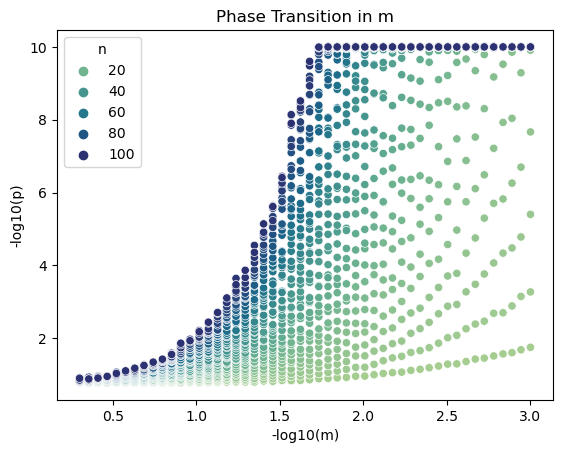

In [36]:
K=5
L = L_list[-2]
K_df = full_df[full_df.K == K]
KL_df = K_df[K_df.L == L]
sns.scatterplot(KL_df,x = '-log(m)',y='p_1',hue='n',palette = 'crest')
plt.title("Phase Transition in m")
plt.xlabel("-log10(m)")
plt.ylabel("-log10(p)")

Text(0, 0.5, '-log10(p)')

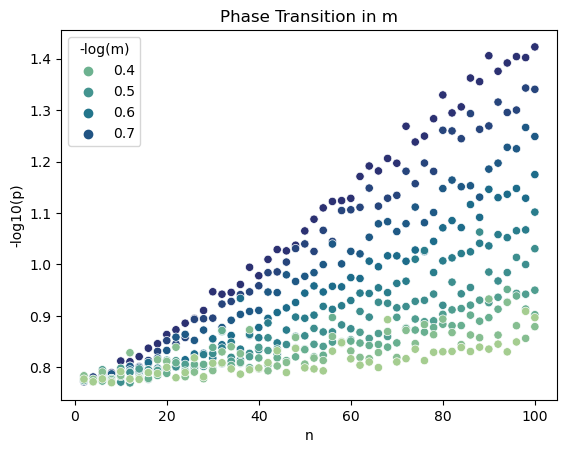

In [41]:
min_m = 0.15
KLm_df = KL_df[KL_df.m>min_m]
sns.scatterplot(KLm_df,x = 'n',y='p_1',hue='-log(m)',palette = 'crest')
plt.title("Phase Transition in n")
plt.xlabel("n")
plt.ylabel("-log10(p)")

## Point of phase transition

In [42]:
cutoff = 0.85
K=5
m_threshold_list,n_threshold_list = compute_threshold_array(KL_df,cutoff=cutoff,p=1)

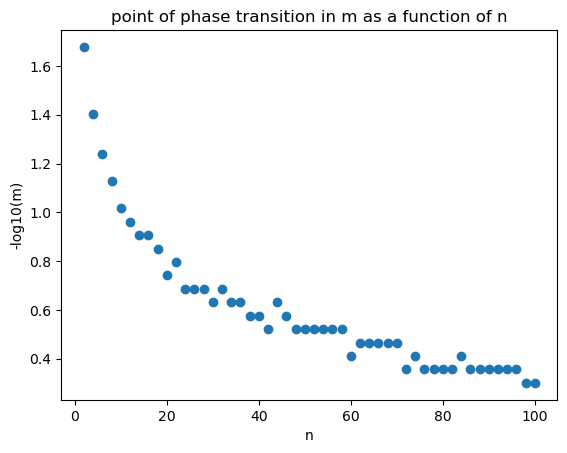

In [43]:
x_values = n_list
y_values = -np.log10(m_threshold_list)

coefficients = np.polyfit(x_values, y_values, 1)
line_of_best_fit = np.polyval(coefficients, x_values)


plt.scatter(x_values, y_values,label='Data points')
# plt.plot(x_values, line_of_best_fit, color='red', label='Line of best fit')
plt.xlabel('n')
plt.ylabel('-log10(m)')
plt.title("point of phase transition in m as a function of n")
# plt.legend()
# plt.grid(True)
plt.show()

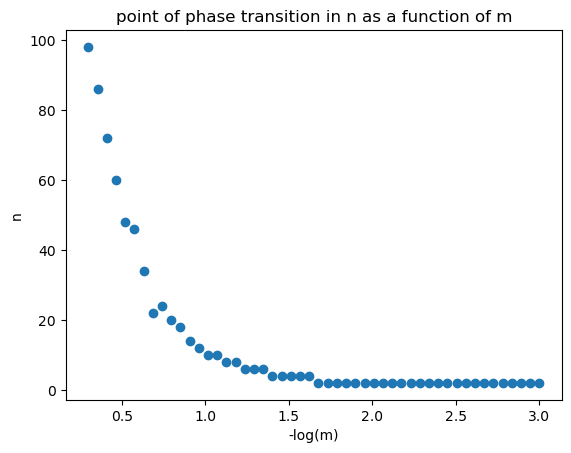

In [45]:
x_values = -np.log10(np.sort(finished_m_dict[5]))[::-1]
y_values = n_threshold_list

coefficients = np.polyfit(x_values, y_values, 1)
line_of_best_fit = np.polyval(coefficients, x_values)


plt.scatter(x_values, y_values,label='Data points')
# plt.plot(x_values, line_of_best_fit, color='red', label='Line of best fit')
plt.xlabel('-log(m)')
plt.ylabel('n')
plt.title("point of phase transition in n as a function of m")
# plt.legend()
# plt.grid(True)
plt.show()

# Eigenvectors

## PC plots

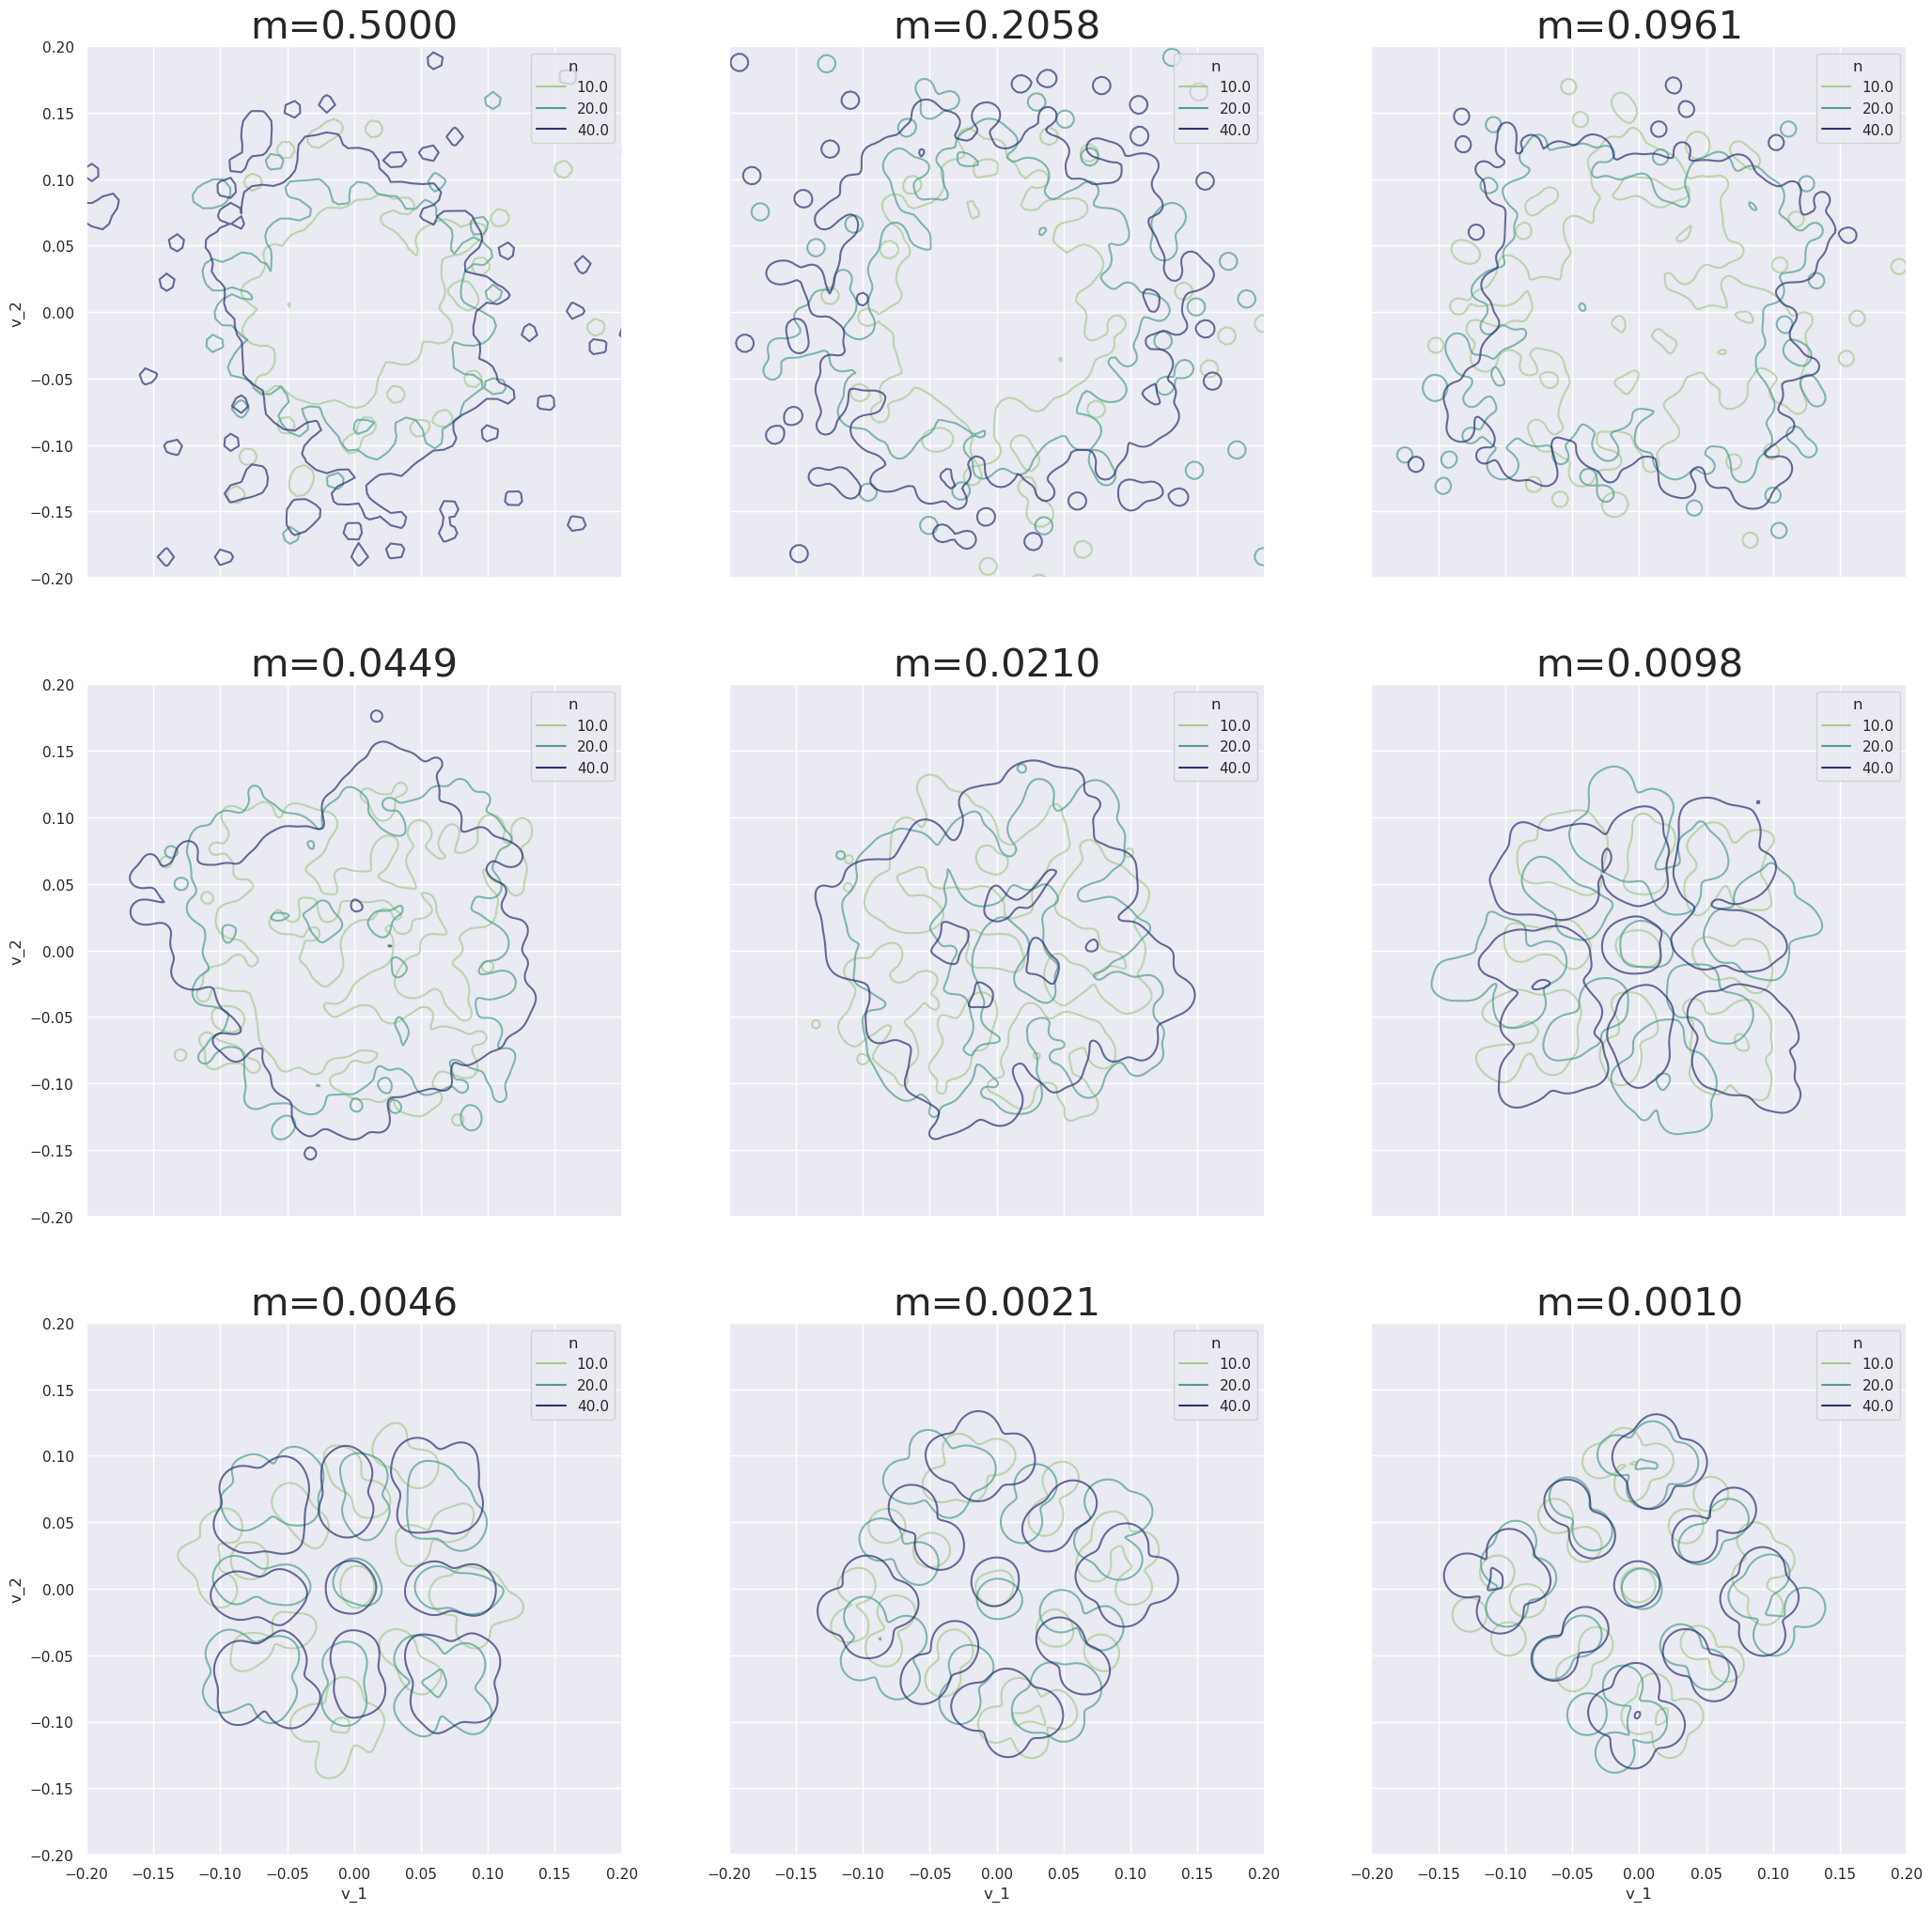

In [154]:
K=5
n_subset = [10,20,40]
max_n = np.max(n_subset)
m_subset = np.sort(finished_m_dict[5])[np.linspace(0,len(finished_m_dict[5])-1,9).astype(int)][::-1]
L = L_list[-2]

sns.set_theme(style="darkgrid")
fig, ax = plt.subplots(3,3,figsize=(25, 25),sharex= True,sharey = True)

for i,m in enumerate(m_subset):
    path = ("../data/eigen_analysis/2d_SS/K=%d/m=%.5f"%(K,m)).rstrip("0")
    eigenvector_df = pd.read_csv(path+"/eigenvectors.csv",index_col=0)
    data_subset  = eigenvector_df.query("n in @n_subset")
    data_subset = data_subset[data_subset.L == L]
    data_subset.v_1 = data_subset.v_1 * np.sqrt(data_subset.n/min(n_subset))
    data_subset.v_2 = data_subset.v_2 * np.sqrt(data_subset.n/min(n_subset))
    temp_ax = ax[i//3,i%3]
    g = sns.kdeplot(
        data=data_subset,
        x="v_1",
        y="v_2",
        hue="n",
        levels = 1,
        bw_method = 0.1,
        ax = temp_ax,
        palette = "crest",
        alpha=0.7
        )

    temp_ax.set_xlim([-0.2,0.2])
    temp_ax.set_ylim([-0.2,0.2])
    temp_ax.set_title("m=%.4f"%m,fontsize = "30")
# handles, labels = ax[-1,-1].get_legend_handles_labels()
# fig.legend(handles, labels,loc = "right",fontsize='xx-large')
#sns.move_legend(g, "center right", bbox_to_anchor=(.55, 1.05))
# fig.supxlabel("PC1",fontsize=24)
# fig.supylabel("PC2",fontsize=24)
# fig.suptitle('PCA density for 1d Stepping Stones Model, K=%d'%K, fontsize=24)
